In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import statistics
import math
from collections import defaultdict

In [2]:
def softmax(x):
    '''
    Input
         x: a vector in ndarray format, 
            typically the raw score of prediction.
    Output 
         a vector in ndarray format,
         typically representing the predicted class probability.
    '''
    res = np.exp(x-np.max(x))
    return res/np.sum(res)

def cross_entropy(y, p):
    '''
    Input
        y: an int representing the class label
        p: a vector in ndarray format showing the predicted
           probability of each class.
           
    Output
        the cross entropy loss. 
    '''
    log_likelihood = -np.log(p)
    return log_likelihood[y]

def relu(x):
    '''
    Input
        x: a vector in ndarray format
    Output
        a vector in ndarray format,
        representing the ReLu activation of x.
    '''
    return np.maximum(x, 0)

In [3]:
class MultiLayerPerceptron():
    '''
    This class defines the multi-layer perceptron we will be using
    as the attack target.
    
    '''
    def __init__(self):
        self.eps = 0.1
        self.labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    
    def load_params(self, params, num_layers=4):
        '''
        This method loads the weights and biases of a trained model.
        '''
        self.W1 = params["fc1.weight"]
        self.b1 = params["fc1.bias"]
        self.W2 = params["fc2.weight"]
        self.b2 = params["fc2.bias"]
        self.W3 = params["fc3.weight"]
        self.b3 = params["fc3.bias"]
        self.W4 = params["fc4.weight"]
        self.b4 = params["fc4.bias"]
        self.layers = num_layers
        
    def set_attack_budget(self, eps):
        '''
        This method sets the maximum L_infty norm of the adversarial
        perturbation.
        '''
        self.eps = eps
        
    def forward(self, x):
        '''
        This method finds the predicted probability vector of an input
        image x.
        
        Input
            x: a single image vector in ndarray format
        Ouput
            a vector in ndarray format representing the predicted class
            probability of x.
            
        Intermediate results are stored as class attributes.
        You might need them for gradient computation.
        '''
        W1, W2, W3, W4 = self.W1, self.W2, self.W3, self.W4
        b1, b2, b3, b4 = self.b1, self.b2, self.b3, self.b4
        self.Ws = [W1, W2, W3, W4]
        
        self.z1 = np.matmul(x,W1)+b1
        self.h1 = relu(self.z1)
        self.z2 = np.matmul(self.h1,W2)+b2
        self.h2 = relu(self.z2)
        self.z3 = np.matmul(self.h2,W3)+b3
        self.h3 = relu(self.z3)
        self.z4 = np.matmul(self.h3,W4)+b4
        self.p = softmax(self.z4)
        self.hs = [self.h1, self.h2, self.h3]
        
        return self.p
        
    def predict(self, x):
        '''
        This method takes a single image vector x and returns the 
        predicted class label of it.
        '''
        res = self.forward(x)
        return np.argmax(res)
    
    def get_one_hot(self, targets, nb_classes):
        res = np.eye(nb_classes, dtype='float32')[np.array(targets).reshape(-1)]
        return res.reshape(list(targets.shape)+[nb_classes])
    
    def gradient_h_z(self, z_idx, h_idx):
        """
        returns dh/dz
        """
        h = self.hs[h_idx-1]
        grad = np.eye(h.shape[0])
        for idx in range(0, len(h)):
            if h[idx] > 0:
                grad[idx][idx] = 1.
            else:
                grad[idx][idx] = 0.
            
        return grad

    def gradient_z_h(self, z_idx, h_idx):
        """
        returns dz/dh
        """
        return self.Ws[z_idx-1].T
        
    
    def gradient(self,x,y):
        ''' 
        This method finds the gradient of the cross-entropy loss
        of an image-label pair (x,y) w.r.t. to the image x.
        
        Input
            x: the input image vector in ndarray format
            y: the true label of x
            
        Output
            a vector in ndarray format representing
            the gradient of the cross-entropy loss of (x,y)
            w.r.t. the image x.
        '''
        
        grad = np.eye(x.shape[0])
        # total number of layers
        l = self.layers
        for idx in range(1, l):
            z_h = self.gradient_z_h(z_idx=idx, h_idx=idx-1)
            h_z = self.gradient_h_z(z_idx=idx, h_idx=idx)
            grad = np.matmul(np.matmul(h_z, z_h), grad)
        
        z_h = self.gradient_z_h(z_idx=l, h_idx=l-1)
        grad = np.matmul(z_h, grad)
        p = np.reshape(self.p, (1, 10))
        y = self.get_one_hot(np.array([y]), len(self.p))
        
        # final gradient
        grad = np.matmul((p-y), grad)
        
        return grad
        
    
    def fgm_attack(self,x,y,eps=None):
        '''
        This method generates the adversarial example of an
        image-label pair (x,y).
        
        Input
            x: an image vector in ndarray format, representing
               the image to be corrupted.
            y: the true label of the image x.
            
        Output
            a vector in ndarray format, representing
            the adversarial example created from image x.
        '''
        y_ = self.predict(x)
        grad = self.gradient(x, y)
        if eps is not None:
            self.eps = eps
        x = np.reshape(x, (1, -1)) + (self.eps * np.sign(grad))
        
        return x
    
    def tfgm_attack(self,x,y,eps=None):
        '''
        This method generates the adversarial example of an
        image-label pair (x,y).
        
        Input
            x: an image vector in ndarray format, representing
               the image to be corrupted.
            y: the true label of the image x.
            
        Output
            a vector in ndarray format, representing
            the adversarial example created from image x.
        '''
        y_ = self.predict(x)
        yt = np.random.choice(self.labels, 1)
        while yt == y:
            yt = np.random.choice(self.labels, 1)

        grad = self.gradient(x, yt)
        if eps is not None:
            self.eps = eps
        x = np.reshape(x, (1, -1)) - (self.eps * np.sign(grad))
        
        return x

In [4]:
X_test = np.load("./data/X_test.npy")
Y_test = np.load("./data/Y_test.npy")

params = {}
param_names = ["fc1.weight", "fc1.bias",
               "fc2.weight", "fc2.bias",
               "fc3.weight", "fc3.bias",
               "fc4.weight", "fc4.bias"]

for name in param_names:
    params[name] = np.load("./data/"+name+'.npy')
    
clf = MultiLayerPerceptron()
clf.load_params(params)

This is an image of Number 7


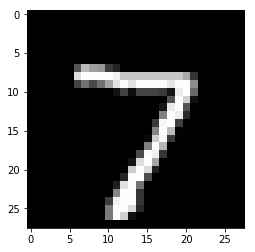

In [5]:
x, y = X_test[0], Y_test[0]
print ("This is an image of Number", y)
pixels = x.reshape((28,28))
plt.imshow(pixels,cmap="gray")

### Accuracy on test data

In [6]:
nTest = 1000
Y_pred = np.zeros(nTest)
for i in range(nTest):
    x, y = X_test[i], Y_test[i]
    Y_pred[i] = clf.predict(x)
acc = np.sum(Y_pred == Y_test[:nTest])*1.0/nTest
print ("Test accuracy is", acc)

Test accuracy is 0.976


### Accuracy on Adversial examples of test data

In [7]:
nTest = 1000
Y_pred_adv = np.zeros(nTest)
for i in range(nTest):
    x, y = X_test[i], Y_test[i]
    x = clf.fgm_attack(x,y)
    Y_pred_adv[i] = clf.predict(x)
    if i%50==0:
        print("original:{}, adversial:{}".format(Y_pred[i], Y_pred_adv[i]))      
acc = np.sum(Y_pred_adv == Y_test[:nTest])*1.0/nTest
print ("Test accuracy on Adversial examples is", acc)

original:7.0, adversial:9.0
original:6.0, adversial:0.0
original:6.0, adversial:5.0
original:9.0, adversial:8.0
original:3.0, adversial:8.0
original:4.0, adversial:9.0
original:4.0, adversial:7.0
original:1.0, adversial:4.0
original:2.0, adversial:0.0
original:3.0, adversial:5.0
original:3.0, adversial:9.0
original:7.0, adversial:9.0
original:6.0, adversial:0.0
original:6.0, adversial:0.0
original:1.0, adversial:8.0
original:0.0, adversial:6.0
original:8.0, adversial:9.0
original:1.0, adversial:7.0
original:1.0, adversial:3.0
original:7.0, adversial:9.0
Test accuracy on Adversial examples is 0.014


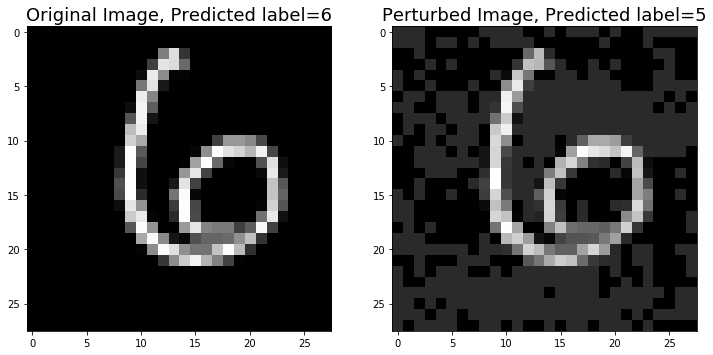

In [8]:
# Plotting a prediction on a sample
x = X_test[100]
y = clf.predict(x)
x_ = clf.fgm_attack(x, y)
y_ = clf.predict(x_)

pixels = x.reshape((28,28))
pixels_ = x_.reshape((28,28))

figure = plt.figure(figsize=(12,12))
ax1 = figure.add_subplot(121)
plt.title("Original Image, Predicted label="+str(y), fontsize=18)
ax1.imshow(pixels,cmap="gray")

ax2 = figure.add_subplot(122)
plt.title("Perturbed Image, Predicted label="+str(y_), fontsize=18)
ax2.imshow(pixels_,cmap="gray")

plt.show()

In [9]:
nTest = 1000
eps = [0.05, 0.1, 0.15, 0.2]
eps_acc = {}
for ep in eps:
    preds = np.zeros(nTest)
    for i in range(nTest):
        x, y = X_test[i], Y_test[i]
        x = clf.fgm_attack(x,y,eps=ep)
        preds[i] = clf.predict(x)
     
    acc = np.sum(preds == Y_test[:nTest])*1.0/nTest
    print ("Test accuracy on Adversial examples with epsilon: {} is: {}".format(ep, acc))
    eps_acc[ep] = acc

Test accuracy on Adversial examples with epsilon: 0.05 is: 0.335
Test accuracy on Adversial examples with epsilon: 0.1 is: 0.014
Test accuracy on Adversial examples with epsilon: 0.15 is: 0.002
Test accuracy on Adversial examples with epsilon: 0.2 is: 0.0


### New Algorithm

### 1.1 Targeted-Fast Gradient Method

In [10]:
nTest = 1000
eps = [0.05, 0.1, 0.15, 0.2]
eps_acc = {}
for ep in eps:
    preds = np.zeros(nTest)
    for i in range(nTest):
        x, y = X_test[i], Y_test[i]
        x = clf.tfgm_attack(x,y,eps=ep)
        preds[i] = clf.predict(x)

    acc = np.sum(preds == Y_test[:nTest])*1.0/nTest
    print ("Test accuracy on Adversial examples with epsilon: {} is: {}".format(ep, acc))
    eps_acc[ep] = acc

Test accuracy on Adversial examples with epsilon: 0.05 is: 0.617
Test accuracy on Adversial examples with epsilon: 0.1 is: 0.101
Test accuracy on Adversial examples with epsilon: 0.15 is: 0.01
Test accuracy on Adversial examples with epsilon: 0.2 is: 0.003


### 1.2 Gaussian Noise Sign Method

In [7]:
def gaussian_noise_attack(x, eps):
    # adds gaussian noise to the data
    x_ = np.random.normal(0., 4., x.shape[0])
    #x_ = np.clip(x_, -1, 1)
    x = x + (eps * np.sign(x_))
    return x

def uniform_noise_attack(x, eps):
    # adds uniform noise to the data
    x_ = np.random.uniform(-4, 4, x.shape[0])
    x = x + (eps * np.sign(x_))
    return x

In [8]:
nTest = 1000
eps = [0.05, 0.10, 0.15, 0.20]
eps_acc = defaultdict(list)
runs = 50
for ep in eps:
    for j in range(runs):
        preds = np.zeros(nTest)
        for i in range(nTest):
            x, y = X_test[i], Y_test[i]
            x = gaussian_noise_attack(x, eps=ep)
            preds[i] = clf.predict(x)
     
        acc = np.sum(preds == Y_test[:nTest])*1.0/nTest
        eps_acc[ep].append(acc*100)
    
    mean = statistics.mean(eps_acc[ep])
    std = statistics.stdev(eps_acc[ep])
    error = (1.96 * std)/ math.sqrt(len(eps_acc[ep]))
    print("Epsilon: {}".format(ep))
    print("Mean accuracy:{}, Standard Deviation:{}".format(mean, std))
    print("Error at confidence of 95%: {}".format(error))

Epsilon: 0.05
Mean accuracy:97.50399999999999, Standard Deviation:0.13395095051121347
Error at confidence of 95%: 0.03712930917752217
Epsilon: 0.1
Mean accuracy:97.2, Standard Deviation:0.2740475156178699
Error at confidence of 95%: 0.07596209581100305
Epsilon: 0.15
Mean accuracy:96.67399999999999, Standard Deviation:0.3042622392017803
Error at confidence of 95%: 0.08433718989864424
Epsilon: 0.2
Mean accuracy:95.71, Standard Deviation:0.47862473050717086
Error at confidence of 95%: 0.1326680066934001


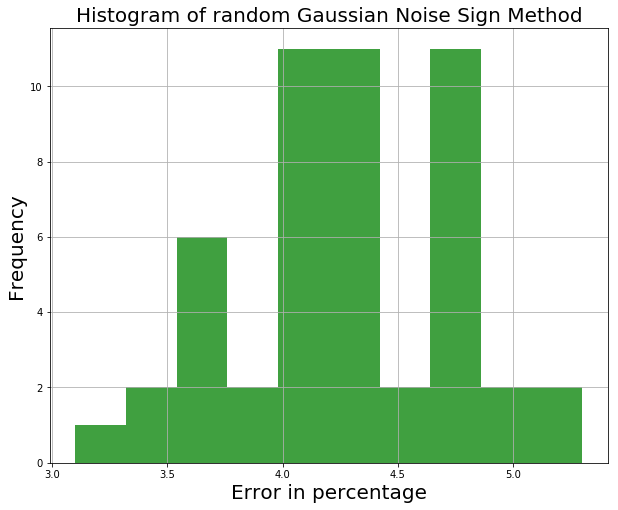

In [11]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))

# the histogram of the data
n, bins, patches = plt.hist(100-np.array(eps_acc[0.20]), facecolor='green', alpha=0.75, bins=10)

plt.xlabel('Error in percentage', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.title('Histogram of random Gaussian Noise Sign Method', fontsize=20)
plt.grid(True)

plt.savefig('gaussnoise.png', format='png', dpi=300)